# ENV

<a target="_blank" href="https://colab.research.google.com/github/ares2012/temp/blob/master/Open_in_Colab.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

https://openincolab.com

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##### API_KEY

In [ ]:
import os
import json

import numpy as np
import pandas as pd

In [ ]:
cp -r /content/drive/MyDrive/Colab\ Notebooks/my_list.txt /content

In [ ]:
file_path = '/content/my_list.txt'

with open(file_path, 'r') as f:
  keys = json.load(f)

oKEY = keys['OPENAI_API_KEY']
pKEY = keys['PINECONE_API_KEY']
hKEY = keys['huggingface.co']

In [ ]:
!pip install openai --upgrade --quiet

##### Successfully installed transformers-4.57.3


* pip install captum bitsandbytes llmlingua
* pip install --upgrade transformers



In [1]:
pip install captum bitsandbytes llmlingua

In [2]:
pip install --upgrade transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 46.8 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.57.2
    Uninstalling transformers-4.57.2:
      Successfully uninstalled transformers-4.57.2


# CDS


In [2]:
import os
import torch

import numpy as np
import pandas as pd
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns

import random
from tqdm import tqdm

from datasets import load_dataset
from transformers import AutoModelForCausalLM, AutoTokenizer
from transformers import AutoConfig, BitsAndBytesConfig
from captum.attr import LayerIntegratedGradients, IntegratedGradients

In [3]:

# ==========================================
# 0. 환경 설정 및 엣지 모델 로드 로컬 (1분)
# ==========================================
torch.cuda.empty_cache()
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

model_name = "microsoft/Phi-3-mini-128k-instruct" #(1분, 52초)
model_name = "Qwen/Qwen3-0.6B" #(25초/1.3G, 6초/3.5G)
local_path = '/content/drive/MyDrive/ColabNotebooks/hub/'

# Construct the path to the model's base directory in the hub
model_base_dir = os.path.join(local_path, "models--" + model_name.replace("/", "--"))

# Construct the path to the snapshots directory
snapshots_dir = os.path.join(model_base_dir, "snapshots")

# Dynamically get the snapshot hash (assuming there's only one subdirectory in snapshots)
if os.path.exists(snapshots_dir):
    snapshot_hashes = os.listdir(snapshots_dir)
    if snapshot_hashes:
        snapshot_hash = snapshot_hashes[0] # Take the first one found
        # Construct the full local path to the model directory including the dynamically found snapshot hash
        local_model_dir = os.path.join(snapshots_dir, snapshot_hash)
    else:
        raise FileNotFoundError(f"No snapshot hashes found in {snapshots_dir}")
else:
    raise FileNotFoundError(f"Snapshots directory not found: {snapshots_dir}")
print(f"Loading model from: {local_model_dir}")

# Explicitly load the configuration first
config = AutoConfig.from_pretrained(local_model_dir, trust_remote_code=True, local_files_only=True)
print(f"Type of config after loading: {type(config)}") # Debugging line

tokenizer = AutoTokenizer.from_pretrained(# model_name,
    local_model_dir, # Use the direct local path
    config=config, # Pass the loaded config
    #trust_remote_code=True
)
print(f"tokenizer.vocab_files_names: {tokenizer.vocab_files_names}")

bnb_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_compute_dtype=torch.float16,
        bnb_4bit_use_double_quant=True,
)
model = AutoModelForCausalLM.from_pretrained(# model_name,
        local_model_dir, # Use the direct local path
        config=config, # Pass the loaded config
        quantization_config=bnb_config,
        device_map="auto",
        trust_remote_code=True,
        attn_implementation="eager",
        #output_attentions=True,
        local_files_only = True # Ensure local files are used
)
# This globally disables the problematic caching mechanism.
model.config.use_cache = False



Loading model from: /content/drive/MyDrive/ColabNotebooks/hub/models--Qwen--Qwen3-0.6B/snapshots/c1899de289a04d12100db370d81485cdf75e47ca
Type of config after loading: <class 'transformers.models.qwen3.configuration_qwen3.Qwen3Config'>
tokenizer.vocab_files_names: {'vocab_file': 'vocab.json', 'merges_file': 'merges.txt', 'tokenizer_file': 'tokenizer.json'}


##### 프롬프트


* apply chat model
* context+question



In [20]:
# ==========================================
# 1. XAI: IG 분석 및 CDS 계산
# ==========================================
from captum.attr import IntegratedGradients
def get_phi3_token_importance(context, question, model, tokenizer):
    # 명시적인 구조를 가진 프롬프트 생성 (Separator 감지 용이)
    # Phi-3 템플릿 + 명확한 구분자
    full_text = f"<|user|>\nContext:\n{context}\n\nQuestion:\n{question}\n\nAnswer based on the context:<|end|>\n<|assistant|>"

    # 0. 입력 ID 추출
    inputs = tokenizer(full_text, return_tensors="pt", add_special_tokens=False).to(DEVICE)
    input_ids = inputs.input_ids
    torch.cuda.empty_cache()

    # 1. Raw Attention 추출 (Forward Pass)
    with torch.no_grad():
      output = model(**inputs); print(type(output))
      # 마지막 레이어의 어텐션 (Batch, Head, Seq, Seq) -> Head 평균 -> (Seq, Seq)
      raw_attn = output.attentions[-1][0].mean(dim=0).cpu().numpy()

    # 2. 임베딩 레이어 찾기
    if hasattr(model, "model") and hasattr(model.model, "embed_tokens"):
        embedding_layer = model.model.embed_tokens
    elif hasattr(model, "embed_tokens"): # Llama/Gemma 일부
        embedding_layer = model.embed_tokens
    else:
        embedding_layer = model.get_input_embeddings()

    # 3. [핵심 수정] 임베딩 벡터를 미리 계산 (이것이 Captum의 Input이 됩니다)
    # 4-bit 모델 등에서 Gradient 계산을 위해 requires_grad 설정이 필요할 수 있음
    input_embeddings = embedding_layer(input_ids)

    # 4. Forward 함수 정의 (임베딩을 입력으로 받음)
    def forward_func(inputs_embeds):
        # inputs_embeds를 모델에 직접 주입
        outputs = model(inputs_embeds=inputs_embeds)
        return outputs.logits[0, -1, :].max().unsqueeze(0)

    # 5. [변경] LayerIntegratedGradients -> IntegratedGradients
    # 레이어가 아니라 '입력 텐서(input_embeddings)' 자체를 분석 대상으로 함
    ig = IntegratedGradients(forward_func)

    # 6. 속성(Attribute) 계산
    try:
        attributions, delta = ig.attribute(
            inputs=input_embeddings,
            # Baseline은 0 벡터 (All-zero embeddings)
            baselines=torch.zeros_like(input_embeddings),
            n_steps=5,
            internal_batch_size=1, # [핵심] 한 번에 1개 단계씩만 계산하여 메모리 절약
            return_convergence_delta=True
        )
    except RuntimeError as e:
      if "out of memory" in str(e):
        print("Skipping sample due to OOM.")
        torch.cuda.empty_cache()
        return None, None, None
      else:
        raise e

    # 7. 중요도 점수 합산 (L2 Norm)
    scores = torch.norm(attributions, dim=-1).squeeze().tolist()
    tokens = tokenizer.convert_ids_to_tokens(input_ids[0])

    # 8. CDS 계산 (Context 영역: 'Question:' 전까지)
    try:
        # 토큰 중 'Question' 문자열을 포함하는 인덱스 찾기
        sep_idx = next(i for i, t in enumerate(tokens) if "Question" in t)
        context_score = sum(scores[:sep_idx])
        total_score = sum(scores)
        cds = context_score / total_score if total_score > 0 else 0
    except StopIteration:
        cds = 0.5 # 구분자 못 찾음
        sep_idx = len(tokens) // 2

    del attributions, delta, inputs, input_ids, input_embeddings
    torch.cuda.empty_cache()

    return tokens, scores, cds, raw_attn

In [4]:
# ==========================================
# 2. 메인 실험 루프 (데이터 수집) 3초
# ==========================================

#dataset = load_dataset('hotpot_qa', 'distractor', split="validation", cache_dir="/content/drive/MyDrive/ColabNotebooks/datasets")
dataset = load_dataset('hotpot_qa', 'distractor', split="validation", cache_dir="/content/drive/MyDrive/ColabNotebooks/hub")

dataset

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

Dataset({
    features: ['id', 'question', 'answer', 'type', 'level', 'supporting_facts', 'context'],
    num_rows: 7405
})

In [21]:
results = []; NUM_SAMPLES = 200  # 논문용으로는 100~200개 권장(10개/1분)
best_viz_candidate = None
max_cds_diff = -1
print(f"\n🚀 Collecting Data from {NUM_SAMPLES} samples...")

for i in tqdm(range(NUM_SAMPLES)):
    data = dataset[i]
    question = data['question']
    # [조건 1] Faithful: 올바른 문맥
    cds_faithful = " ".join(["".join(sent) for sent in data['context']['sentences']])
    # [조건 2] Hallucinated: 무관한 문맥 (랜덤 샘플링)
    rand_idx = random.randint(0, len(dataset)-1)
    while rand_idx == i: rand_idx = random.randint(0, len(dataset)-1)
    cds_hallucinated = " ".join(["".join(sent) for sent in dataset[rand_idx]['context']['sentences']])
    # 분석 실행
    tok_f, score_f, cds_f, attn_f = get_phi3_token_importance(cds_faithful, question, model, tokenizer)
    tok_h, score_h, cds_h, attn_h = get_phi3_token_importance(cds_hallucinated, question, model, tokenizer)
    if cds_f is None or cds_h is None: continue # 에러/OOM 스킵

    # 결과 저장
    diff = cds_f - cds_h
    results.append({        "id": i,        "cds_faithful": cds_f,
                    "cds_hallucinated": cds_h,        "diff": diff    })
    # 시각화용 '최고의 샘플' 저장 (차이가 가장 큰 것)
    if diff > max_cds_diff:
      max_cds_diff = diff
      best_viz_candidate = {
          "tok_f": tok_f, "score_f": score_f, "attn_f": attn_f,
          "tok_h": tok_h, "score_h": score_h, "attn_h": attn_h,
          "q": question        }



🚀 Collecting Data from 200 samples...


  0%|          | 0/200 [00:00<?, ?it/s]

<class 'transformers.modeling_outputs.CausalLMOutputWithPast'>


TypeError: 'NoneType' object is not subscriptable

In [9]:
# ==========================================
# 3. 정량 분석: 통계 검정 (T-test)
# ==========================================
df = pd.DataFrame(results)
t_stat, p_val = stats.ttest_rel(df['cds_faithful'], df['cds_hallucinated'])

print("\n" + "="*50)
print("📊 [Phase 1] Quantitative Results")
print("="*50)
print(f"Mean CDS (Faithful):     {df['cds_faithful'].mean():.4f} (std: {df['cds_faithful'].std():.4f})")
print(f"Mean CDS (Hallucinated): {df['cds_hallucinated'].mean():.4f} (std: {df['cds_hallucinated'].std():.4f})")
print(f"Gap (Faithful - Hallucinated): {df['diff'].mean():.4f}")
print("-" * 50)
print(f"Statistical Significance (Paired T-test):")
print(f"T-statistic: {t_stat:.4f}")
print(f"P-value:     {p_val:.4e}")
if p_val < 0.05:
    print("✅ Result: Statistically Significant (p < 0.05)")
else:
    print("❌ Result: Not Significant")

# CSV 저장
df.to_csv("phase1_experiment_results.csv", index=False)



📊 [Phase 1] Quantitative Results
Mean CDS (Faithful):     0.5342 (std: 0.0307)
Mean CDS (Hallucinated): 0.5266 (std: 0.0274)
Gap (Faithful - Hallucinated): 0.0076
--------------------------------------------------
Statistical Significance (Paired T-test):
T-statistic: 2.4122
P-value:     1.6939e-02
✅ Result: Statistically Significant (p < 0.05)


✅ Figure 1 Saved.


TypeError: list indices must be integers or slices, not tuple

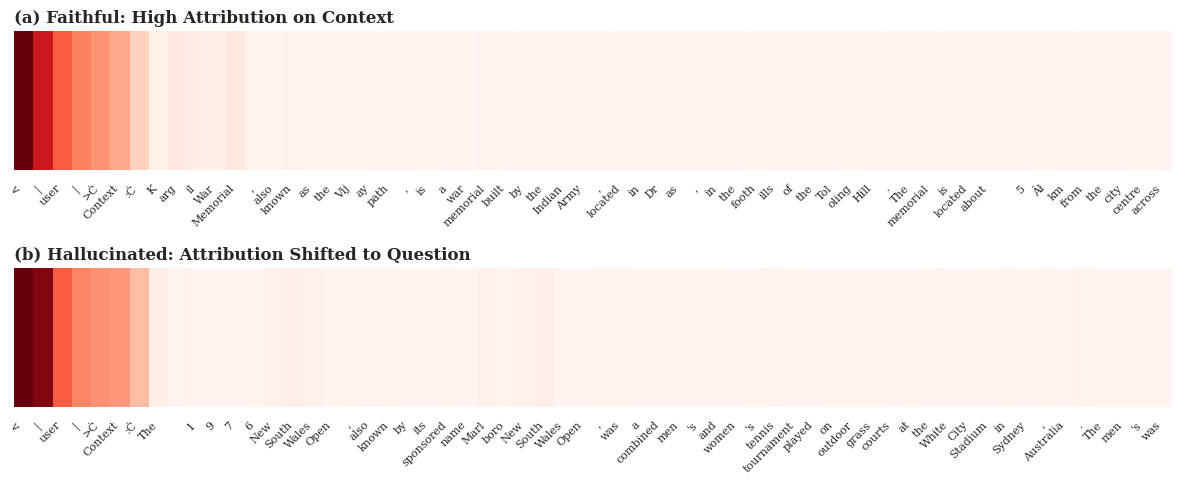

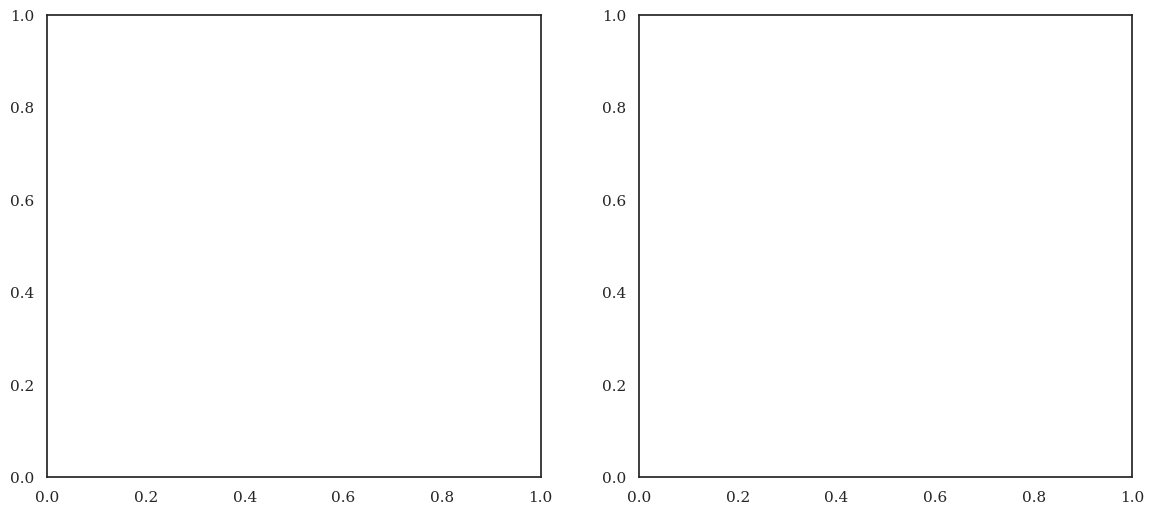

In [11]:
# ==========================================
# 4. 정성 분석 시각화 (Figure 1 & 2)
# ==========================================
if best_viz_candidate:
    sns.set_theme(style="white")
    plt.rcParams['font.family'] = 'serif'
    # --- Figure 1: Heatmap Comparison (Intensity) ---
    fig1, axes = plt.subplots(2, 1, figsize=(12, 5))

    def draw_heatmap(ax, tokens, scores, title):
      limit = 60
      clean = [t.replace(' ', '').replace('Ġ', '') for t in tokens][:limit]
      vals = np.array(scores)[:limit].reshape(1, -1)
      vals = (vals - vals.min()) / (vals.max() - vals.min() + 1e-9) # Normalize

      sns.heatmap(vals, xticklabels=clean, yticklabels=False, cmap="Reds", ax=ax, cbar=False)
      ax.set_title(title, loc='left', fontsize=12, fontweight='bold')
      ax.set_xticklabels(clean, rotation=45, ha='right', fontsize=8)

    draw_heatmap(axes[0], best_viz_candidate['tok_f'], best_viz_candidate['score_f'], "(a) Faithful: High Attribution on Context")
    draw_heatmap(axes[1], best_viz_candidate['tok_h'], best_viz_candidate['score_h'], "(b) Hallucinated: Attribution Shifted to Question")

    plt.tight_layout()
    plt.savefig("fig1_heatmap.png", dpi=300)
    print("✅ Figure 1 Saved.")

    # --- Figure 2: Attention Map Comparison (Structure) ---
    # 어텐션 맵은 N x N 이므로 잘라서(Crop) 보여주는 것이 좋음
    fig2, axes = plt.subplots(1, 2, figsize=(14, 6))

    def draw_attn_map(ax, tokens, attn_mat, title):
      limit = 40 # 40x40 토큰만 시각화 (가독성 위함)
      clean = [t.replace(' ', '').replace('Ġ', '') for t in tokens][:limit]
      mat = attn_mat[:limit, :limit]

      sns.heatmap(mat, xticklabels=clean, yticklabels=clean, cmap="Blues", ax=ax, cbar=False, square=True)
      ax.set_title(title, fontsize=12, fontweight='bold')
      ax.tick_params(axis='x', rotation=90, labelsize=7)
      ax.tick_params(axis='y', rotation=0, labelsize=7)

    draw_attn_map(axes[0], best_viz_candidate['tok_f'], best_viz_candidate['attn_f'], "(a) Faithful Attention Structure")
    draw_attn_map(axes[1], best_viz_candidate['tok_h'], best_viz_candidate['attn_h'], "(b) Hallucinated Attention Structure")

    plt.tight_layout()
    plt.savefig("fig2_attention_map.png", dpi=300)
    print("✅ Figure 2 Saved.")

In [ ]:
# ==========================================
# 4. 정성 분석: Figure 1 히트맵 생성
# ==========================================
if best_viz_candidate:
    print(f"\n🎨 Generating Figure 1 from Sample ID (Best Gap)...")

    sns.set_theme(style="white")
    plt.rcParams['font.family'] = 'serif'
    fig, axes = plt.subplots(2, 1, figsize=(12, 5), sharex=False)
    def draw_row(ax, tokens, scores, title):
        # 시각화 길이 제한
        limit = 70
        clean_toks = [t.replace(' ', '').replace('Ġ', '') for t in tokens][:limit]
        norm_scores = np.array(scores)[:limit]
        # 정규화
        if norm_scores.max() > 0:
            norm_scores /= norm_scores.max()
        sns.heatmap(
            norm_scores.reshape(1, -1),
            xticklabels=clean_toks, yticklabels=False,
            cmap="Reds", ax=ax, cbar=True,
            cbar_kws={"orientation": "vertical", "shrink": 0.8}
        )
        ax.set_title(title, fontsize=12, fontweight='bold', loc='left')
        ax.set_xticklabels(clean_toks, rotation=45, ha='right', fontsize=8)
    draw_row(axes[0], best_viz_candidate['tok_f'], best_viz_candidate['score_f'],
             f"(a) Faithful Generation (Correct Context) - High Attention on Context")
    draw_row(axes[1], best_viz_candidate['tok_h'], best_viz_candidate['score_h'],
             f"(b) Hallucination Risk (Irrelevant Context) - Attention Shifted to Question")

    plt.tight_layout()
    plt.savefig("phase1_figure1_heatmap.png", bbox_inches='tight', dpi=300)
    print("✅ Saved 'phase1_figure1_heatmap.png'")

print("\n🎉 Phase 1 Experiment Complete.")